In [9]:
%load_ext autoreload
%autoreload 2
import datalib as dl
import nn
import params as p
import pandas as pd
from hyperopt import fmin, tpe, hp, Trials, space_eval
from hyperopt.pyll.base import scope
import shutil
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Tuning Moon Model

In [79]:
def runNN2(adr_period=14):
    ds = dl.load_data(p.ticker, p.currency)
    ds['DR'] = ds['close']/ds['close'].shift(1)
    ds['ADR'] = ds['DR'].rolling(window=adr_period).mean()

    calendar = dl.get_calendar(ds.date.min(), ds.date.max())
    ds = pd.merge(calendar, ds, on='date', how='left')
    ds = ds.dropna()

    for col in calendar.columns:
        if col == 'date':
            continue
        ds = dl.encode(ds, col, 359)

    td = nn.train_test_nn(ds)
    return td.CSR.iloc[-1]

In [80]:
p.load_config('ETHUSDNN2')


**************** Loaded Config for ETHUSDNN2 ****************


Loaded ETHUSD prices from KRAKEN via kr Rows:720 Date:2020-10-05 00:00:00
Last complete day close: 352.54


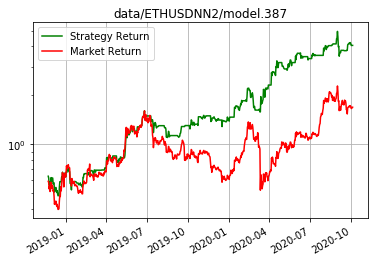

Strategy Return: 4.05
Market Return: 1.69
Sortino Ratio: 2.21
Bars in Trade: 4
Buy Pct: 0.52
Accuracy: 0.55
Win Ratio: 0.59
Avg Win: 0.04
Avg Loss: 0.03
Risk to Reward: 1.39
Expectancy: 0.96
Sharpe Ratio: 1.36
Average Daily Return: 0.003
SL: 0.00 TP: 0.00


4.050595824255538

In [81]:
runNN2()

Loaded ETHUSD prices from KRAKEN via cc Rows:1887 Date:2020-10-05 00:00:00
Last complete day close: 352.54


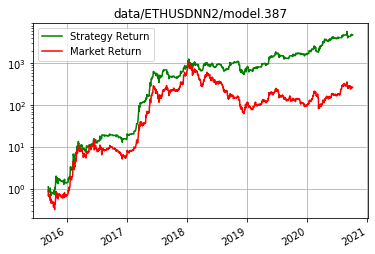

Strategy Return: 4734.73
Market Return: 265.08
Sortino Ratio: 3.75
Bars in Trade: 4
Buy Pct: 0.54
Accuracy: 0.56
Win Ratio: 0.61
Avg Win: 0.06
Avg Loss: 0.03
Risk to Reward: 2.19
Expectancy: 2.43
Sharpe Ratio: 2.12
Average Daily Return: 0.007
SL: 0.00 TP: 0.00


4734.725830660757

In [82]:
p.datasource = 'cc'
runNN2()

In [100]:
space = {
    'adr_period': scope.int(hp.quniform('adr_period', 1, 30, 1))
}

In [101]:
def f(space):
    print('Testing Parameters: '+str(space))
    sr = runNN2(
        adr_period=space['adr_period']
    )
    
    if sr > p.top_sr:
        print('*** SR Improved!!! ***')
        shutil.move(p.model, p.cfgdir+'/top_model.nn')
        shutil.move(p.cfgdir + '/sc.dmp', p.cfgdir + '/top_sc.dmp')
        shutil.move(p.cfgdir + '/sc1.dmp', p.cfgdir + '/top_sc1.dmp')
        p.top_sr = sr
    
    print('SR: '+str(sr))
    
    return -sr

In [107]:
p.datasource = 'cc'
p.model = p.cfgdir+'/model.nn'
p.reload = False
p.charts = False
p.stats = False
p.train = True
p.train_pct = 0.8
p.test_pct = 0.2
p.epochs = 30
p.batch_size = 100
p.top_sr = 0

trials = Trials()

best = fmin(
    fn=f,
    space=space,
    algo=tpe.suggest,
    trials=trials,
    max_evals=100
)

Testing Parameters: {'adr_period': 19}                 
Using loaded prices for 2020-10-06                     
*** Training model with 32 units per layer ***         
*** SR Improved!!! ***                                 
SR: 2.9722280188689734                                 
Testing Parameters: {'adr_period': 13}                                            
Using loaded prices for 2020-10-06                                                
*** Training model with 32 units per layer ***                                    
SR: 1.780129079615761                                                             
Testing Parameters: {'adr_period': 15}                                            
Using loaded prices for 2020-10-06                                                
*** Training model with 32 units per layer ***                                    
SR: 1.8818584897177377                                                            
Testing Parameters: {'adr_period': 23}                  

SR: 1.1755637391042737                                                            
Testing Parameters: {'adr_period': 8}                                             
Using loaded prices for 2020-10-06                                                
*** Training model with 32 units per layer ***                                    
SR: 1.7103582883072068                                                            
Testing Parameters: {'adr_period': 1}                                             
Using loaded prices for 2020-10-06                                                
*** Training model with 32 units per layer ***                                    
SR: 0.6510170632567149                                                            
Testing Parameters: {'adr_period': 24}                                            
Using loaded prices for 2020-10-06                                                
*** Training model with 32 units per layer ***                                    
SR: 

SR: 2.6757110368646506                                                            
Testing Parameters: {'adr_period': 13}                                            
Using loaded prices for 2020-10-06                                                
*** Training model with 32 units per layer ***                                    
SR: 1.6357147406533619                                                            
Testing Parameters: {'adr_period': 24}                                            
Using loaded prices for 2020-10-06                                                
*** Training model with 32 units per layer ***                                    
SR: 2.626782816570993                                                             
100%|██████████| 100/100 [04:16<00:00,  2.57s/trial, best loss: -3.835512372276387]


In [108]:
# Best: 19
best

{'adr_period': 19.0}

Using loaded prices for 2020-10-06


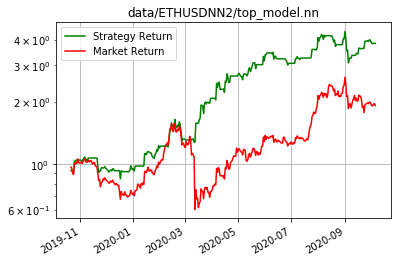

Strategy Return: 3.84
Market Return: 1.91
Sortino Ratio: 4.14
Bars in Trade: 3
Buy Pct: 0.53
Accuracy: 0.57
Win Ratio: 0.59
Avg Win: 0.04
Avg Loss: 0.02
Risk to Reward: 1.76
Expectancy: 1.59
Sharpe Ratio: 2.24
Average Daily Return: 0.004
SL: 0.00 TP: 0.00


3.835512372276387

In [110]:
shutil.move(p.cfgdir + '/top_sc.dmp', p.cfgdir + '/sc.dmp')
shutil.move(p.cfgdir + '/top_sc1.dmp', p.cfgdir + '/sc1.dmp')

p.train = False
p.model = p.cfgdir+'/top_model.nn'
p.test_pct = 0.2
p.charts = True
p.stats = True

runNN2(int(best['adr_period']))

Using loaded prices for 2020-10-06


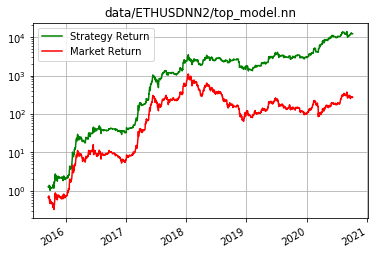

Strategy Return: 12149.37
Market Return: 271.32
Sortino Ratio: 4.10
Bars in Trade: 4
Buy Pct: 0.58
Accuracy: 0.57
Win Ratio: 0.62
Avg Win: 0.07
Avg Loss: 0.03
Risk to Reward: 2.19
Expectancy: 3.10
Sharpe Ratio: 2.29
Average Daily Return: 0.008
SL: 0.00 TP: 0.00


12149.374766194425

In [111]:
p.test_pct = 1
runNN2(int(best['adr_period']))

# Tuning Risk Model

In [32]:
p.load_config('ETHUSDNN1')


**************** Loaded Config for ETHUSDNN1 ****************


Loaded ETHUSD prices from KRAKEN via cc Rows:1907 Date:2020-10-25 00:00:00
Last complete day close: 412.38
Loaded ETHBTC prices from KRAKEN via cc Rows:1907 Date:2020-10-25 00:00:00
Last complete day close: 0.03141


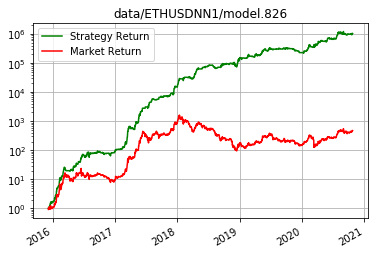

Strategy Return: 1040829.50
Market Return: 474.70
Sortino Ratio: 8.26
Bars in Trade: 3
Buy Pct: 0.54
Accuracy: 0.58
Win Ratio: 0.60
Avg Win: 0.07
Avg Loss: 0.02
Risk to Reward: 3.62
Expectancy: 3.66
Sharpe Ratio: 3.63
Average Daily Return: 0.010
SL: 0.00 TP: 0.00


In [34]:
p.datasource = 'cc'
td = nn.runNN1()

In [37]:
td[td.y_pred].SR.prod()

1040829.5033152888

Loaded ETHUSD prices from KRAKEN via cc Rows:1907 Date:2020-10-25 00:00:00
Last complete day close: 412.38
Loaded ETHBTC prices from KRAKEN via cc Rows:1907 Date:2020-10-25 00:00:00
Last complete day close: 0.03141


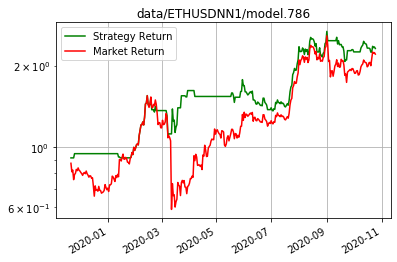

Strategy Return: 2.31
Market Return: 2.20
Sortino Ratio: 2.93
Bars in Trade: 6
Buy Pct: 0.47
Accuracy: 0.51
Win Ratio: 0.33
Avg Win: 0.10
Avg Loss: 0.02
Risk to Reward: 4.82
Expectancy: 1.24
Sharpe Ratio: 1.70
Average Daily Return: 0.003
SL: 0.00 TP: 0.00


In [28]:
p.test_pct = 0.2
td = nn.runNN1()

Loaded ETHUSD prices from KRAKEN via cc Rows:1907 Date:2020-10-25 00:00:00
Last complete day close: 412.38
Loaded ETHBTC prices from KRAKEN via cc Rows:1907 Date:2020-10-25 00:00:00
Last complete day close: 0.03141


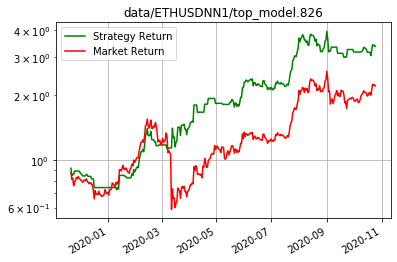

Strategy Return: 3.36
Market Return: 2.20
Sortino Ratio: 3.88
Bars in Trade: 4
Buy Pct: 0.59
Accuracy: 0.52
Win Ratio: 0.51
Avg Win: 0.06
Avg Loss: 0.02
Risk to Reward: 2.47
Expectancy: 1.59
Sharpe Ratio: 2.12
Average Daily Return: 0.004
SL: 0.00 TP: 0.00


In [29]:
p.model = p.cfgdir+'/model.826'
td1 = nn.runNN1()

Loaded ETHUSD prices from KRAKEN via kr Rows:720 Date:2020-10-25 00:00:00
Last complete day close: 412.38
Loaded ETHBTC prices from KRAKEN via kr Rows:720 Date:2020-10-25 00:00:00
Last complete day close: 0.03141


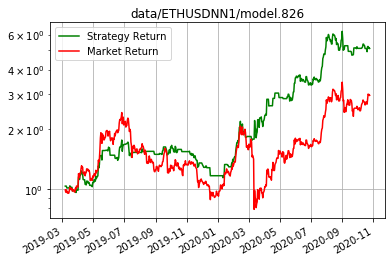

Strategy Return: 5.11
Market Return: 2.97
Sortino Ratio: 3.31
Bars in Trade: 4
Buy Pct: 0.52
Accuracy: 0.53
Win Ratio: 0.51
Avg Win: 0.04
Avg Loss: 0.02
Risk to Reward: 2.14
Expectancy: 1.23
Sharpe Ratio: 1.84
Average Daily Return: 0.003
SL: 0.00 TP: 0.00


In [33]:
p.test_pct = 1
td1 = nn.runNN1()

In [6]:
space = {
    'adx_period': scope.int(hp.quniform('adx_period', 2, 10, 1))
}

In [7]:
def f(space):
    print('Testing Parameters: '+str(space))
    sr = nn.runNN1().CSR.iloc[-1]
    
    if sr > p.top_sr:
        print('*** SR Improved!!! ***')
        mpath = p.cfgdir+'/top_model.nn'
        if os.path.exists(mpath):
            shutil.rmtree(mpath) 
        shutil.move(p.model, mpath)
        shutil.move(p.cfgdir + '/sc.dmp', p.cfgdir + '/top_sc.dmp')
        shutil.move(p.cfgdir + '/sc1.dmp', p.cfgdir + '/top_sc1.dmp')
        p.top_sr = sr
    
    print('SR: '+str(sr))
    return -sr

Testing Parameters: {'adx_period': 6}                 
Using loaded prices for 2020-10-25                    
Using loaded prices for 2020-10-25                    
*** Training model with 32 units per layer ***        
                                                      
Epoch 00001: val_loss improved from inf to 0.15463, saving model to data/ETHUSDNN1/model.nn
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]INFO:tensorflow:Assets written to: data/ETHUSDNN1/model.nn/assets
                                                      
Epoch 00002: val_loss improved from 0.15463 to 0.09888, saving model to data/ETHUSDNN1/model.nn
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]INFO:tensorflow:Assets written to: data/ETHUSDNN1/model.nn/assets
                                                      
Epoch 00003: val_loss improved from 0.09888 to 0.02876, saving model to data/ETHUSDNN1/model.nn
  0%|          | 0/10 [00:01<?, ?trial/s, best loss=?]INFO:tensorflow:Assets written to: da

                                                      
Epoch 00047: val_loss did not improve from 0.00670
                                                      
Epoch 00048: val_loss did not improve from 0.00670
                                                      
Epoch 00049: val_loss did not improve from 0.00670
                                                      
Epoch 00050: val_loss did not improve from 0.00670
                                                      
Epoch 00051: val_loss did not improve from 0.00670
                                                      
Epoch 00052: val_loss improved from 0.00670 to 0.00665, saving model to data/ETHUSDNN1/model.nn
  0%|          | 0/10 [00:10<?, ?trial/s, best loss=?]INFO:tensorflow:Assets written to: data/ETHUSDNN1/model.nn/assets
                                                      
Epoch 00053: val_loss did not improve from 0.00665
                                                      
Epoch 00054: val_loss did not improve 

                                                      
Epoch 00115: val_loss did not improve from 0.00642
                                                      
Epoch 00116: val_loss did not improve from 0.00642
                                                      
Epoch 00117: val_loss did not improve from 0.00642
                                                      
Epoch 00118: val_loss improved from 0.00642 to 0.00640, saving model to data/ETHUSDNN1/model.nn
  0%|          | 0/10 [00:15<?, ?trial/s, best loss=?]INFO:tensorflow:Assets written to: data/ETHUSDNN1/model.nn/assets
                                                      
Epoch 00119: val_loss did not improve from 0.00640
                                                      
Epoch 00120: val_loss did not improve from 0.00640
                                                      
Epoch 00121: val_loss did not improve from 0.00640
                                                      
Epoch 00122: val_loss did not improve 

                                                      
Epoch 00191: val_loss did not improve from 0.00640
                                                      
Epoch 00192: val_loss did not improve from 0.00640
                                                      
Epoch 00193: val_loss did not improve from 0.00640
                                                      
Epoch 00194: val_loss did not improve from 0.00640
                                                      
Epoch 00195: val_loss did not improve from 0.00640
                                                      
Epoch 00196: val_loss did not improve from 0.00640
                                                      
Epoch 00197: val_loss did not improve from 0.00640
                                                      
Epoch 00198: val_loss did not improve from 0.00640
                                                      
Epoch 00199: val_loss did not improve from 0.00640
                                              

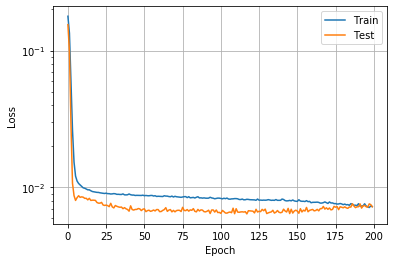

*** SR Improved!!! ***                                
SR: 2.9034944998129717                                
Testing Parameters: {'adx_period': 3}                                            
Using loaded prices for 2020-10-25                                               
Using loaded prices for 2020-10-25                                               
*** Training model with 32 units per layer ***                                   
                                                                                 
Epoch 00001: val_loss improved from inf to 0.15240, saving model to data/ETHUSDNN1/model.nn
 10%|█         | 1/10 [00:19<02:49, 18.84s/trial, best loss: -2.9034944998129717]INFO:tensorflow:Assets written to: data/ETHUSDNN1/model.nn/assets
                                                                                 
Epoch 00002: val_loss improved from 0.15240 to 0.09135, saving model to data/ETHUSDNN1/model.nn
 10%|█         | 1/10 [00:19<02:49, 18.84s/trial, best loss: -2

                                                                                 
Epoch 00033: val_loss did not improve from 0.00669
                                                                                 
Epoch 00034: val_loss did not improve from 0.00669
                                                                                 
Epoch 00035: val_loss improved from 0.00669 to 0.00660, saving model to data/ETHUSDNN1/model.nn
 10%|█         | 1/10 [00:28<02:49, 18.84s/trial, best loss: -2.9034944998129717]INFO:tensorflow:Assets written to: data/ETHUSDNN1/model.nn/assets
                                                                                 
Epoch 00036: val_loss did not improve from 0.00660
                                                                                 
Epoch 00037: val_loss improved from 0.00660 to 0.00654, saving model to data/ETHUSDNN1/model.nn
 10%|█         | 1/10 [00:28<02:49, 18.84s/trial, best loss: -2.9034944998129717]INFO:tensorflow:A

                                                                                 
Epoch 00083: val_loss did not improve from 0.00626
                                                                                 
Epoch 00084: val_loss did not improve from 0.00626
                                                                                 
Epoch 00085: val_loss did not improve from 0.00626
                                                                                 
Epoch 00086: val_loss improved from 0.00626 to 0.00624, saving model to data/ETHUSDNN1/model.nn
 10%|█         | 1/10 [00:33<02:49, 18.84s/trial, best loss: -2.9034944998129717]INFO:tensorflow:Assets written to: data/ETHUSDNN1/model.nn/assets
                                                                                 
Epoch 00087: val_loss did not improve from 0.00624
                                                                                 
Epoch 00088: val_loss did not improve from 0.00624
          

                                                                                 
Epoch 00143: val_loss did not improve from 0.00624
                                                                                 
Epoch 00144: val_loss did not improve from 0.00624
                                                                                 
Epoch 00145: val_loss did not improve from 0.00624
                                                                                 
Epoch 00146: val_loss did not improve from 0.00624
                                                                                 
Epoch 00147: val_loss did not improve from 0.00624
                                                                                 
Epoch 00148: val_loss did not improve from 0.00624
                                                                                 
Epoch 00149: val_loss did not improve from 0.00624
                                                                     

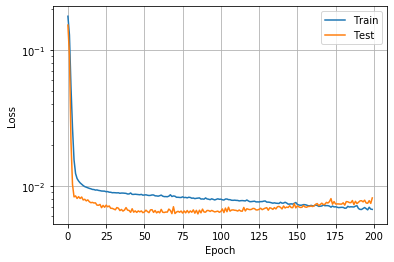

*** SR Improved!!! ***                                                           
SR: 3.631950410758106                                                            
Testing Parameters: {'adx_period': 7}                                            
Using loaded prices for 2020-10-25                                              
Using loaded prices for 2020-10-25                                              
*** Training model with 32 units per layer ***                                  
                                                                                
Epoch 00001: val_loss improved from inf to 0.15031, saving model to data/ETHUSDNN1/model.nn
 20%|██        | 2/10 [00:38<02:31, 18.93s/trial, best loss: -3.631950410758106]INFO:tensorflow:Assets written to: data/ETHUSDNN1/model.nn/assets
                                                                                
Epoch 00002: val_loss improved from 0.15031 to 0.08814, saving model to data/ETHUSDNN1/model.nn
 20%|██        

                                                                                
Epoch 00036: val_loss did not improve from 0.00698
                                                                                
Epoch 00037: val_loss did not improve from 0.00698
                                                                                
Epoch 00038: val_loss did not improve from 0.00698
                                                                                
Epoch 00039: val_loss improved from 0.00698 to 0.00696, saving model to data/ETHUSDNN1/model.nn
 20%|██        | 2/10 [00:46<02:31, 18.93s/trial, best loss: -3.631950410758106]INFO:tensorflow:Assets written to: data/ETHUSDNN1/model.nn/assets
                                                                                
Epoch 00040: val_loss did not improve from 0.00696
                                                                                
Epoch 00041: val_loss improved from 0.00696 to 0.00691, saving model

                                                                                
Epoch 00082: val_loss did not improve from 0.00642
                                                                                
Epoch 00083: val_loss did not improve from 0.00642
                                                                                
Epoch 00084: val_loss did not improve from 0.00642
                                                                                
Epoch 00085: val_loss did not improve from 0.00642
                                                                                
Epoch 00086: val_loss did not improve from 0.00642
                                                                                
Epoch 00087: val_loss did not improve from 0.00642
                                                                                
Epoch 00088: val_loss did not improve from 0.00642
                                                                            

                                                                                
Epoch 00141: val_loss did not improve from 0.00633
                                                                                
Epoch 00142: val_loss did not improve from 0.00633
                                                                                
Epoch 00143: val_loss did not improve from 0.00633
                                                                                
Epoch 00144: val_loss did not improve from 0.00633
                                                                                
Epoch 00145: val_loss did not improve from 0.00633
                                                                                
Epoch 00146: val_loss did not improve from 0.00633
                                                                                
Epoch 00147: val_loss did not improve from 0.00633
                                                                            

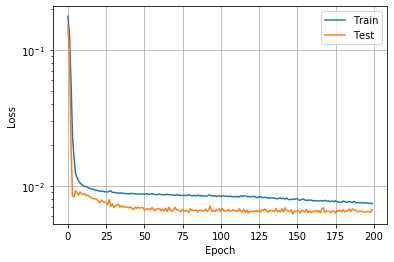

SR: 1.7607469642662539                                                          
Testing Parameters: {'adx_period': 7}                                           
Using loaded prices for 2020-10-25                                              
Using loaded prices for 2020-10-25                                              
*** Training model with 32 units per layer ***                                  
                                                                                
Epoch 00001: val_loss improved from inf to 0.15441, saving model to data/ETHUSDNN1/model.nn
 30%|███       | 3/10 [00:58<02:15, 19.32s/trial, best loss: -3.631950410758106]INFO:tensorflow:Assets written to: data/ETHUSDNN1/model.nn/assets
                                                                                
Epoch 00002: val_loss improved from 0.15441 to 0.09588, saving model to data/ETHUSDNN1/model.nn
 30%|███       | 3/10 [00:59<02:15, 19.32s/trial, best loss: -3.631950410758106]INFO:tensorflow:Ass

                                                                                
Epoch 00035: val_loss did not improve from 0.00681
                                                                                
Epoch 00036: val_loss did not improve from 0.00681
                                                                                
Epoch 00037: val_loss improved from 0.00681 to 0.00676, saving model to data/ETHUSDNN1/model.nn
 30%|███       | 3/10 [01:07<02:15, 19.32s/trial, best loss: -3.631950410758106]INFO:tensorflow:Assets written to: data/ETHUSDNN1/model.nn/assets
                                                                                
Epoch 00038: val_loss did not improve from 0.00676
                                                                                
Epoch 00039: val_loss did not improve from 0.00676
                                                                                
Epoch 00040: val_loss did not improve from 0.00676
                 

                                                                                
Epoch 00088: val_loss did not improve from 0.00651
                                                                                
Epoch 00089: val_loss did not improve from 0.00651
                                                                                
Epoch 00090: val_loss did not improve from 0.00651
                                                                                
Epoch 00091: val_loss did not improve from 0.00651
                                                                                
Epoch 00092: val_loss did not improve from 0.00651
                                                                                
Epoch 00093: val_loss did not improve from 0.00651
                                                                                
Epoch 00094: val_loss did not improve from 0.00651
                                                                            

                                                                                
Epoch 00150: val_loss did not improve from 0.00651
                                                                                
Epoch 00151: val_loss did not improve from 0.00651
                                                                                
Epoch 00152: val_loss did not improve from 0.00651
                                                                                
Epoch 00153: val_loss did not improve from 0.00651
                                                                                
Epoch 00154: val_loss did not improve from 0.00651
                                                                                
Epoch 00155: val_loss did not improve from 0.00651
                                                                                
Epoch 00156: val_loss did not improve from 0.00651
                                                                            

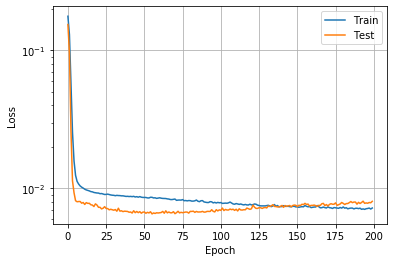

SR: 1.5211387835445203                                                          
Testing Parameters: {'adx_period': 10}                                          
Using loaded prices for 2020-10-25                                              
Using loaded prices for 2020-10-25                                              
*** Training model with 32 units per layer ***                                  
                                                                                
Epoch 00001: val_loss improved from inf to 0.15188, saving model to data/ETHUSDNN1/model.nn
 40%|████      | 4/10 [01:15<01:52, 18.70s/trial, best loss: -3.631950410758106]INFO:tensorflow:Assets written to: data/ETHUSDNN1/model.nn/assets
                                                                                
Epoch 00002: val_loss improved from 0.15188 to 0.08954, saving model to data/ETHUSDNN1/model.nn
 40%|████      | 4/10 [01:16<01:52, 18.70s/trial, best loss: -3.631950410758106]INFO:tensorflow:Ass

                                                                                
Epoch 00034: val_loss did not improve from 0.00687
                                                                                
Epoch 00035: val_loss did not improve from 0.00687
                                                                                
Epoch 00036: val_loss improved from 0.00687 to 0.00685, saving model to data/ETHUSDNN1/model.nn
 40%|████      | 4/10 [01:24<01:52, 18.70s/trial, best loss: -3.631950410758106]INFO:tensorflow:Assets written to: data/ETHUSDNN1/model.nn/assets
                                                                                
Epoch 00037: val_loss did not improve from 0.00685
                                                                                
Epoch 00038: val_loss did not improve from 0.00685
                                                                                
Epoch 00039: val_loss improved from 0.00685 to 0.00677, saving model

                                                                                
Epoch 00083: val_loss did not improve from 0.00647
                                                                                
Epoch 00084: val_loss did not improve from 0.00647
                                                                                
Epoch 00085: val_loss did not improve from 0.00647
                                                                                
Epoch 00086: val_loss did not improve from 0.00647
                                                                                
Epoch 00087: val_loss did not improve from 0.00647
                                                                                
Epoch 00088: val_loss improved from 0.00647 to 0.00643, saving model to data/ETHUSDNN1/model.nn
 40%|████      | 4/10 [01:30<01:52, 18.70s/trial, best loss: -3.631950410758106]INFO:tensorflow:Assets written to: data/ETHUSDNN1/model.nn/assets
                 

                                                                                
Epoch 00144: val_loss did not improve from 0.00643
                                                                                
Epoch 00145: val_loss did not improve from 0.00643
                                                                                
Epoch 00146: val_loss did not improve from 0.00643
                                                                                
Epoch 00147: val_loss did not improve from 0.00643
                                                                                
Epoch 00148: val_loss did not improve from 0.00643
                                                                                
Epoch 00149: val_loss did not improve from 0.00643
                                                                                
Epoch 00150: val_loss did not improve from 0.00643
                                                                            

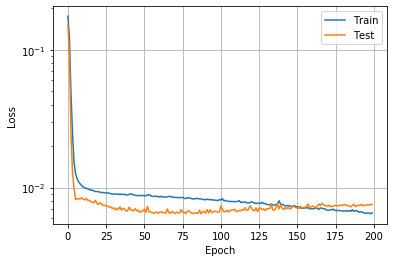

SR: 2.2935677718927967                                                          
Testing Parameters: {'adx_period': 8}                                           
Using loaded prices for 2020-10-25                                              
Using loaded prices for 2020-10-25                                              
*** Training model with 32 units per layer ***                                  
                                                                                
Epoch 00001: val_loss improved from inf to 0.14945, saving model to data/ETHUSDNN1/model.nn
 50%|█████     | 5/10 [01:35<01:34, 18.90s/trial, best loss: -3.631950410758106]INFO:tensorflow:Assets written to: data/ETHUSDNN1/model.nn/assets
                                                                                
Epoch 00002: val_loss improved from 0.14945 to 0.08773, saving model to data/ETHUSDNN1/model.nn
 50%|█████     | 5/10 [01:35<01:34, 18.90s/trial, best loss: -3.631950410758106]INFO:tensorflow:Ass

                                                                                
Epoch 00034: val_loss did not improve from 0.00673
                                                                                
Epoch 00035: val_loss did not improve from 0.00673
                                                                                
Epoch 00036: val_loss did not improve from 0.00673
                                                                                
Epoch 00037: val_loss did not improve from 0.00673
                                                                                
Epoch 00038: val_loss did not improve from 0.00673
                                                                                
Epoch 00039: val_loss did not improve from 0.00673
                                                                                
Epoch 00040: val_loss improved from 0.00673 to 0.00652, saving model to data/ETHUSDNN1/model.nn
 50%|█████     | 5/10 [01:44<01

                                                                                
Epoch 00089: val_loss did not improve from 0.00635
                                                                                
Epoch 00090: val_loss did not improve from 0.00635
                                                                                
Epoch 00091: val_loss did not improve from 0.00635
                                                                                
Epoch 00092: val_loss did not improve from 0.00635
                                                                                
Epoch 00093: val_loss did not improve from 0.00635
                                                                                
Epoch 00094: val_loss did not improve from 0.00635
                                                                                
Epoch 00095: val_loss did not improve from 0.00635
                                                                            

                                                                                
Epoch 00151: val_loss did not improve from 0.00635
                                                                                
Epoch 00152: val_loss did not improve from 0.00635
                                                                                
Epoch 00153: val_loss did not improve from 0.00635
                                                                                
Epoch 00154: val_loss did not improve from 0.00635
                                                                                
Epoch 00155: val_loss did not improve from 0.00635
                                                                                
Epoch 00156: val_loss did not improve from 0.00635
                                                                                
Epoch 00157: val_loss did not improve from 0.00635
                                                                            

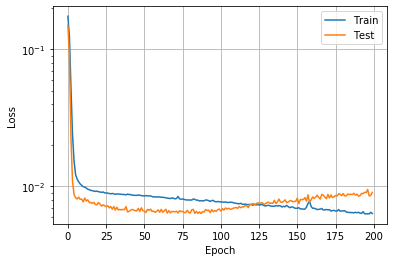

SR: 2.9800267465980075                                                          
Testing Parameters: {'adx_period': 2}                                           
Using loaded prices for 2020-10-25                                              
Using loaded prices for 2020-10-25                                              
*** Training model with 32 units per layer ***                                  
                                                                                
Epoch 00001: val_loss improved from inf to 0.15373, saving model to data/ETHUSDNN1/model.nn
 60%|██████    | 6/10 [01:52<01:13, 18.43s/trial, best loss: -3.631950410758106]INFO:tensorflow:Assets written to: data/ETHUSDNN1/model.nn/assets
                                                                                
Epoch 00002: val_loss improved from 0.15373 to 0.09469, saving model to data/ETHUSDNN1/model.nn
 60%|██████    | 6/10 [01:53<01:13, 18.43s/trial, best loss: -3.631950410758106]INFO:tensorflow:Ass

                                                                                
Epoch 00035: val_loss did not improve from 0.00651
                                                                                
Epoch 00036: val_loss did not improve from 0.00651
                                                                                
Epoch 00037: val_loss did not improve from 0.00651
                                                                                
Epoch 00038: val_loss did not improve from 0.00651
                                                                                
Epoch 00039: val_loss did not improve from 0.00651
                                                                                
Epoch 00040: val_loss did not improve from 0.00651
                                                                                
Epoch 00041: val_loss did not improve from 0.00651
                                                                            

                                                                                
Epoch 00088: val_loss did not improve from 0.00612
                                                                                
Epoch 00089: val_loss did not improve from 0.00612
                                                                                
Epoch 00090: val_loss did not improve from 0.00612
                                                                                
Epoch 00091: val_loss did not improve from 0.00612
                                                                                
Epoch 00092: val_loss did not improve from 0.00612
                                                                                
Epoch 00093: val_loss did not improve from 0.00612
                                                                                
Epoch 00094: val_loss did not improve from 0.00612
                                                                            

                                                                                
Epoch 00150: val_loss did not improve from 0.00612
                                                                                
Epoch 00151: val_loss did not improve from 0.00612
                                                                                
Epoch 00152: val_loss did not improve from 0.00612
                                                                                
Epoch 00153: val_loss did not improve from 0.00612
                                                                                
Epoch 00154: val_loss did not improve from 0.00612
                                                                                
Epoch 00155: val_loss did not improve from 0.00612
                                                                                
Epoch 00156: val_loss did not improve from 0.00612
                                                                            

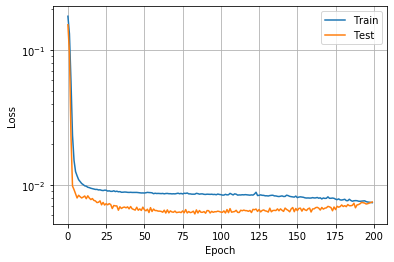

SR: 2.2221596487960573                                                          
Testing Parameters: {'adx_period': 7}                                           
Using loaded prices for 2020-10-25                                              
Using loaded prices for 2020-10-25                                              
*** Training model with 32 units per layer ***                                  
                                                                                
Epoch 00001: val_loss improved from inf to 0.14721, saving model to data/ETHUSDNN1/model.nn
 70%|███████   | 7/10 [02:09<00:54, 18.09s/trial, best loss: -3.631950410758106]INFO:tensorflow:Assets written to: data/ETHUSDNN1/model.nn/assets
                                                                                
Epoch 00002: val_loss improved from 0.14721 to 0.07710, saving model to data/ETHUSDNN1/model.nn
 70%|███████   | 7/10 [02:10<00:54, 18.09s/trial, best loss: -3.631950410758106]INFO:tensorflow:Ass

 70%|███████   | 7/10 [02:18<00:54, 18.09s/trial, best loss: -3.631950410758106]INFO:tensorflow:Assets written to: data/ETHUSDNN1/model.nn/assets
                                                                                
Epoch 00035: val_loss improved from 0.00671 to 0.00671, saving model to data/ETHUSDNN1/model.nn
 70%|███████   | 7/10 [02:18<00:54, 18.09s/trial, best loss: -3.631950410758106]INFO:tensorflow:Assets written to: data/ETHUSDNN1/model.nn/assets
                                                                                
Epoch 00036: val_loss did not improve from 0.00671
                                                                                
Epoch 00037: val_loss improved from 0.00671 to 0.00670, saving model to data/ETHUSDNN1/model.nn
 70%|███████   | 7/10 [02:19<00:54, 18.09s/trial, best loss: -3.631950410758106]INFO:tensorflow:Assets written to: data/ETHUSDNN1/model.nn/assets
                                                                            

                                                                                
Epoch 00084: val_loss did not improve from 0.00640
                                                                                
Epoch 00085: val_loss did not improve from 0.00640
                                                                                
Epoch 00086: val_loss did not improve from 0.00640
                                                                                
Epoch 00087: val_loss did not improve from 0.00640
                                                                                
Epoch 00088: val_loss did not improve from 0.00640
                                                                                
Epoch 00089: val_loss did not improve from 0.00640
                                                                                
Epoch 00090: val_loss did not improve from 0.00640
                                                                            

                                                                                
Epoch 00143: val_loss did not improve from 0.00631
                                                                                
Epoch 00144: val_loss did not improve from 0.00631
                                                                                
Epoch 00145: val_loss did not improve from 0.00631
                                                                                
Epoch 00146: val_loss did not improve from 0.00631
                                                                                
Epoch 00147: val_loss did not improve from 0.00631
                                                                                
Epoch 00148: val_loss did not improve from 0.00631
                                                                                
Epoch 00149: val_loss did not improve from 0.00631
                                                                            

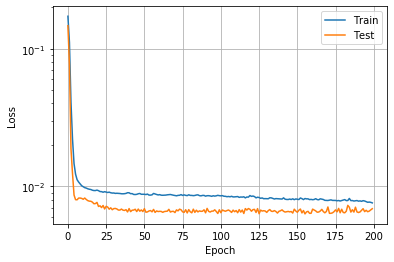

SR: 2.41742736107871                                                            
Testing Parameters: {'adx_period': 9}                                           
Using loaded prices for 2020-10-25                                              
Using loaded prices for 2020-10-25                                              
*** Training model with 32 units per layer ***                                  
                                                                                
Epoch 00001: val_loss improved from inf to 0.15385, saving model to data/ETHUSDNN1/model.nn
 80%|████████  | 8/10 [02:29<00:37, 18.57s/trial, best loss: -3.631950410758106]INFO:tensorflow:Assets written to: data/ETHUSDNN1/model.nn/assets
                                                                                
Epoch 00002: val_loss improved from 0.15385 to 0.09729, saving model to data/ETHUSDNN1/model.nn
 80%|████████  | 8/10 [02:30<00:37, 18.57s/trial, best loss: -3.631950410758106]INFO:tensorflow:Ass

                                                                                
Epoch 00037: val_loss improved from 0.00707 to 0.00689, saving model to data/ETHUSDNN1/model.nn
 80%|████████  | 8/10 [02:37<00:37, 18.57s/trial, best loss: -3.631950410758106]INFO:tensorflow:Assets written to: data/ETHUSDNN1/model.nn/assets
                                                                                
Epoch 00038: val_loss did not improve from 0.00689
                                                                                
Epoch 00039: val_loss did not improve from 0.00689
                                                                                
Epoch 00040: val_loss did not improve from 0.00689
                                                                                
Epoch 00041: val_loss improved from 0.00689 to 0.00678, saving model to data/ETHUSDNN1/model.nn
 80%|████████  | 8/10 [02:38<00:37, 18.57s/trial, best loss: -3.631950410758106]INFO:tensorflow:Assets w

                                                                                
Epoch 00090: val_loss did not improve from 0.00649
                                                                                
Epoch 00091: val_loss did not improve from 0.00649
                                                                                
Epoch 00092: val_loss did not improve from 0.00649
                                                                                
Epoch 00093: val_loss did not improve from 0.00649
                                                                                
Epoch 00094: val_loss did not improve from 0.00649
                                                                                
Epoch 00095: val_loss did not improve from 0.00649
                                                                                
Epoch 00096: val_loss improved from 0.00649 to 0.00645, saving model to data/ETHUSDNN1/model.nn
 80%|████████  | 8/10 [02:41<00

                                                                                
Epoch 00145: val_loss did not improve from 0.00632
                                                                                
Epoch 00146: val_loss did not improve from 0.00632
                                                                                
Epoch 00147: val_loss did not improve from 0.00632
                                                                                
Epoch 00148: val_loss did not improve from 0.00632
                                                                                
Epoch 00149: val_loss did not improve from 0.00632
                                                                                
Epoch 00150: val_loss did not improve from 0.00632
                                                                                
Epoch 00151: val_loss did not improve from 0.00632
                                                                            

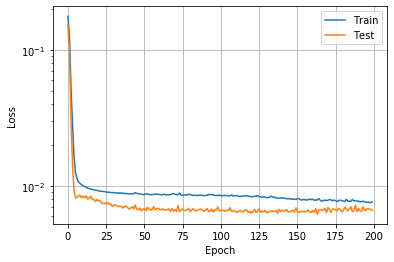

SR: 2.4072220428527253                                                          
Testing Parameters: {'adx_period': 4}                                           
Using loaded prices for 2020-10-25                                              
Using loaded prices for 2020-10-25                                              
*** Training model with 32 units per layer ***                                  
                                                                                
Epoch 00001: val_loss improved from inf to 0.15095, saving model to data/ETHUSDNN1/model.nn
 90%|█████████ | 9/10 [02:49<00:18, 18.84s/trial, best loss: -3.631950410758106]INFO:tensorflow:Assets written to: data/ETHUSDNN1/model.nn/assets
                                                                                
Epoch 00002: val_loss improved from 0.15095 to 0.08659, saving model to data/ETHUSDNN1/model.nn
 90%|█████████ | 9/10 [02:49<00:18, 18.84s/trial, best loss: -3.631950410758106]INFO:tensorflow:Ass

                                                                                
Epoch 00035: val_loss improved from 0.00698 to 0.00685, saving model to data/ETHUSDNN1/model.nn
 90%|█████████ | 9/10 [02:57<00:18, 18.84s/trial, best loss: -3.631950410758106]INFO:tensorflow:Assets written to: data/ETHUSDNN1/model.nn/assets
                                                                                
Epoch 00036: val_loss did not improve from 0.00685
                                                                                
Epoch 00037: val_loss did not improve from 0.00685
                                                                                
Epoch 00038: val_loss improved from 0.00685 to 0.00678, saving model to data/ETHUSDNN1/model.nn
 90%|█████████ | 9/10 [02:57<00:18, 18.84s/trial, best loss: -3.631950410758106]INFO:tensorflow:Assets written to: data/ETHUSDNN1/model.nn/assets
                                                                                
Epoch 000

                                                                                
Epoch 00085: val_loss did not improve from 0.00634
                                                                                
Epoch 00086: val_loss did not improve from 0.00634
                                                                                
Epoch 00087: val_loss did not improve from 0.00634
                                                                                
Epoch 00088: val_loss did not improve from 0.00634
                                                                                
Epoch 00089: val_loss did not improve from 0.00634
                                                                                
Epoch 00090: val_loss did not improve from 0.00634
                                                                                
Epoch 00091: val_loss did not improve from 0.00634
                                                                            

                                                                                
Epoch 00147: val_loss did not improve from 0.00634
                                                                                
Epoch 00148: val_loss did not improve from 0.00634
                                                                                
Epoch 00149: val_loss did not improve from 0.00634
                                                                                
Epoch 00150: val_loss did not improve from 0.00634
                                                                                
Epoch 00151: val_loss did not improve from 0.00634
                                                                                
Epoch 00152: val_loss did not improve from 0.00634
                                                                                
Epoch 00153: val_loss did not improve from 0.00634
                                                                            

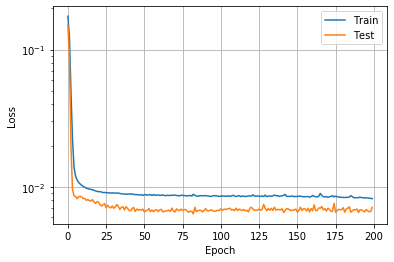

SR: 1.6360698057013643                                                          
100%|██████████| 10/10 [03:06<00:00, 18.67s/trial, best loss: -3.631950410758106]
Best Parameters:
{'adx_period': 3}
Using loaded prices for 2020-10-25
Using loaded prices for 2020-10-25


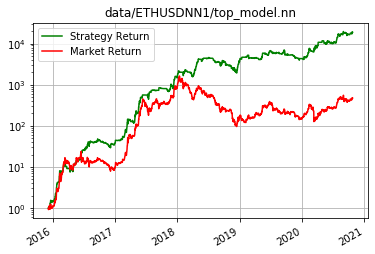

Strategy Return: 18908.77
Market Return: 473.50
Sortino Ratio: 5.70
Bars in Trade: 3
Buy Pct: 0.48
Accuracy: 0.54
Win Ratio: 0.50
Avg Win: 0.07
Avg Loss: 0.02
Risk to Reward: 3.25
Expectancy: 2.53
Sharpe Ratio: 2.79
Average Daily Return: 0.007
SL: 0.00 TP: 0.00


In [23]:
p.datasource = 'cc'
p.model = p.cfgdir+'/model.nn'
p.reload = False
p.train = True
p.train_pct = 0.8
p.test_pct = 0.2
p.epochs = 200
p.batch_size = 100

p.charts = False
p.stats = False
p.top_sr = 0

trials = Trials()

best = fmin(
    fn=f,
    space=space,
    algo=tpe.suggest,
    trials=trials,
    max_evals=10
)

params = space_eval(space, best)
print('Best Parameters:')
print(params)

shutil.move(p.cfgdir + '/top_sc.dmp', p.cfgdir + '/sc.dmp')
shutil.move(p.cfgdir + '/top_sc1.dmp', p.cfgdir + '/sc1.dmp')

p.train = False
p.model = p.cfgdir+'/top_model.nn'
p.test_pct = 1
p.charts = True
p.stats = True

td = nn.runNN1()

p.test_pct = 0.2
td1 = nn.runNN1()